# Sprint24 Seq2Seq

## 【問題1】機械翻訳の実行とコードリーディング

以下のサンプルコードは、短い英語からフランス語への変換を行うものです。これを動かしてください。


[https://github.com/rstudio/keras/blob/master/vignettes/examples/lstm_seq2seq.py](https://github.com/rstudio/keras/blob/master/vignettes/examples/lstm_seq2seq.py)


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。

以下のようにどこからどこの行が何をしているかを記述してください。


**（例）**

51から55行目 : ライブラリのimport

57から62行目 : ハイパーパラメータの設定

**《文字単位のトークン化》**


この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。


scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、

charやchar_wbとすることで文字を扱えるようになります。


charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。

逆にcharは単語の区切りが関係なくn_gramが作成されます。

This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。


sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.21.3 documentation

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
ls

In [ ]:
cd image_captioning/

In [ ]:
!unzip pytorch-tutorial-master.zip

In [ ]:
# Seq2Seqのサンプルコード
'''Kerasでのsequence to sequenceの例（文字レベル）。
このスクリプトは、文字レベルの基本的な配列対配列モデルを実装する方法を示します。
sequence-to-sequenceモデルを実装する方法を示します。英語の短文をフランス語の短文に翻訳する際に適用します。
英語の短文をフランス語の短文に翻訳します。
一文字ずつ翻訳します。なお、文字レベルの機械翻訳を行うのはかなり珍しいことです。
この分野では単語レベルの機械翻訳が一般的なので、文字レベルの機械翻訳を行うのはかなり珍しいことです。
この分野では単語レベルのモデルが一般的です。
# アルゴリズムの概要を説明します。
- ある分野の入力配列（例：英語の文章）と、それに対応する別の分野の目標配列を用意します。
    と、それに対応する別ドメインのターゲットシーケンス
    (例：フランス語の文)からの対応するターゲットシーケンスから始める。
- エンコーダLSTMは、入力配列を2つの状態ベクトル
    (に変換する（LSTMの最後の状態を保持し、出力は破棄する）。)
- デコーダLSTMは、対象となる配列を、同じ配列だが1つの時間だけオフセットした配列に変換するように学習されます。
    同じシーケンスを1タイムステップ先にオフセットしたシーケンスに変換するように学習されます。
    この学習プロセスは，ここでは "教師強制 "と呼ばれています．
    デコーダのLSTMは、エンコーダの状態ベクトルを初期状態として使用する。
    事実上，デコーダは，「ターゲット［...］」が与えられたときに，「ターゲット［t+1...］」を生成することを学習する．
    を生成することを学習します．
- 推論モードでは、未知の入力シーケンスをデコードする場合、次のようにします。
    - 入力配列を状態ベクトルにエンコードする
    - サイズ1のターゲットシーケンスから始める
        (配列開始文字のみ)
    - 状態ベクトルと1文字のターゲット配列をデコーダに渡して
        次の文字の予測値を生成するために，デコーダに渡す
    - この予測値を使って次の文字をサンプリングする
        (ここでは単純にargmaxを使用)。
    - サンプリングした文字をターゲットシーケンスに追加する
    - シーケンスの終わりの文字が生成されるか、文字数制限に達するまで繰り返します。
        文字数制限に達するまで繰り返します。
# 
# データのダウンロード
# 
英語とフランス語の文のペア。
https://www.manythings.org/anki/fra-eng.zip
たくさんの素敵な文のペアのデータセットが以下のサイトにあります。
https://www.manythings.org/anki/
# 参考文献
- ニューラルネットワークによる塩基配列の学習
    https://arxiv.org/abs/1409.3215
- フレーズ表現の学習
    統計的機械翻訳のためのRNNエンコーダ-デコーダ
    https://arxiv.org/abs/1406.1078
'''

# www.DeepL.com/Translator（無料版）で翻訳しました。

from __future__ import print_function
from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # トレーニング用のバッチサイズ
epochs = 100  # エポック数
latent_dim = 256  # 符号化空間の潜在的な次元数
num_samples = 10000  # 学習対象となるサンプル数
# ディスク上のデータtxtファイルへのパス
data_path = 'fra.txt'

# データをベクトル化する
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    # print(line)
    # print(line.split('\t'))
    input_text, target_text, _ = line.split('\t')
    # ターゲットの "スタートシーケンス "文字として "tab "を使用
    # ターゲットには "tab "を、"end sequence "には"\"を使用します。
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        #decoder_target_dataがdecoder_input_dataよりも1タイムステップ分進んでいる。
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_dataは、1タイムステップ前になります。
            # 開始文字は含まれません
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# 入力シーケンスを定義し、それを処理します。
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# `encoder_outputs` を破棄して、状態のみを保持する。
encoder_states = [state_h, state_c]

# 初期状態として `encoder_states` を使用して、デコーダを設定します。
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# デコーダーを設定して、完全な出力シーケンスを返すようにした。
# そして、内部状態も返すように設定します。返した状態は学習モデルでは使用しませんが
# トレーニングモデルでは使用しませんが、推論では使用します。
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 次のようなモデルを定義します。
# `encoder_input_data` & `decoder_input_data` を `decoder_target_data` に変換するモデルを定義する。

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# モデルをコンパイルしてfitする
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# モデル保存
model.save('s2s.h5')

# Next: 推論モード（サンプリング）.
# 以下はその手順である。
# 1) 入力を符号化し、デコーダの初期状態を取得する
# 2) この初期状態でデコーダの1ステップを実行する
# 2) この初期状態でデコーダの1ステップを実行する # そして "start of sequence" トークンをターゲットにする
# 出力は次のターゲット・トークンとなる
# 3) 現在のターゲット・トークンと現在の状態で繰り返す

# サンプリングモデル
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# 逆引きされたトークン・インデックスは、シーケンスをデコードして
# 読めるようにする。
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # 入力を状態ベクトルとしてエンコードする。
    states_value = encoder_model.predict(input_seq)

    # 長さ1の空のターゲット配列を生成します。
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # ターゲットシーケンスの最初の文字を開始文字として入力します
    target_seq[0, 0, target_token_index['\t']] = 1.

    # 配列のバッチに対するサンプリングループ
    # (簡単にするために、ここではサイズ1のバッチを想定しています。)
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        #トークンのサンプル
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # 終了条件: 最大長に達するか
        # または停止文字を見つける。
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # 対象となる配列（長さ1）を更新する。
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # 更新内容
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # 1つのシーケンスを取る (トレーニングテストの一部)
    # デコーディングを試すために
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

## イメージキャプショニング

他の活用例としてイメージキャプショニングがあります。

画像に対する説明の文章を推定するタスクです。

これは画像を入力し、系列データを出力する Image to Sequence の手法によって行えます。


[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning)


イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにします。

Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱います。

## 【問題2】イメージキャプショニングの学習済みモデルの実行


上記実装において 5. Test the model の項目を実行してください。

また、自身で用意した画像に対しても文章を生成してください。

これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。

ここは書き換える必要があります。

In [ ]:
/content/drive/MyDrive/Colab Notebooks/DIC_sprint/o0500042013965008391.jpeg

In [ ]:
!git clone https://github.com/pdollar/coco.git

In [ ]:
!pip install -r requirements.txt
!pip install torchvision 
!pip install pycocotools

In [47]:
# ライブラリimport
import torch
import torchvision
%matplotlib inline

In [48]:
ls

build_vocab.py  data_loader.py  model.py  README.md         resize.py  train.py
coco/           download.sh*    png/      requirements.txt  sample.py


In [ ]:
!unzip  pretrained_model.zip

In [ ]:
ls

In [ ]:
cd image_captioning/ 

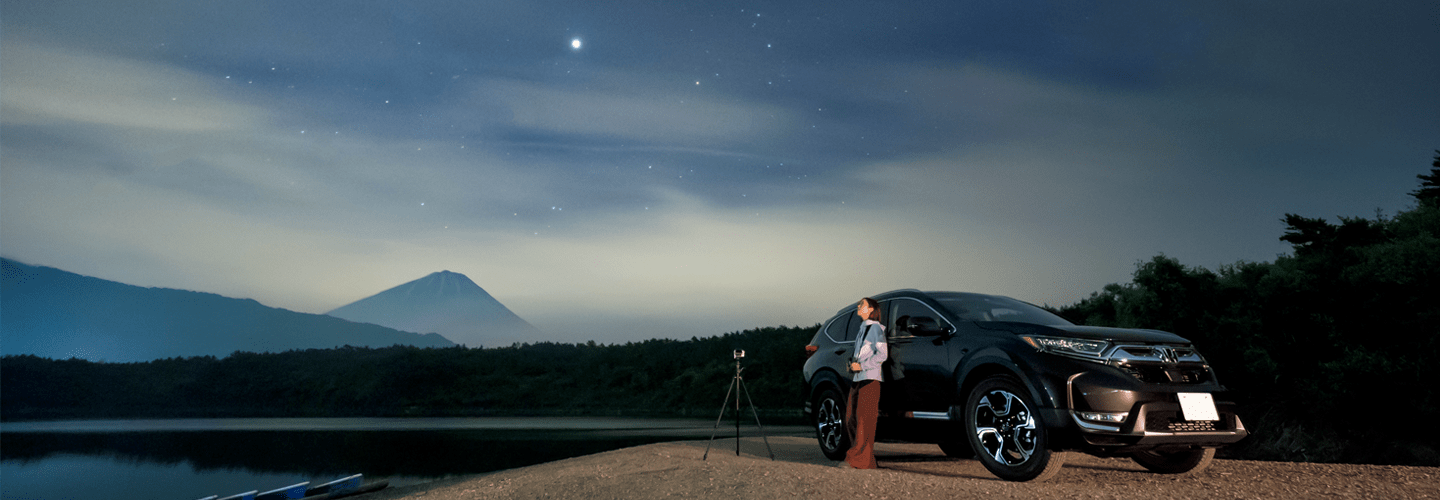

In [55]:
from IPython.display import Image,display_png
display_png(Image('../../../../main_pc.png'))

In [91]:
# サンプルのモデル
!python sample.py --image='main_pc.png'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<start> a motorcycle parked in a field next to a body of water . <end>


In [92]:
ls

build_vocab.py                      models/
coco/                               png/
data/                               pretrained_model.zip
data_loader.py                      __pycache__/
download.sh*                        README.md
generative_adversarial_network/     requirements.txt
IMG_2423.png                        resize.py
istockphoto-1188421171-612x612.png  sample.py
main_pc.png                         train.py
model.py


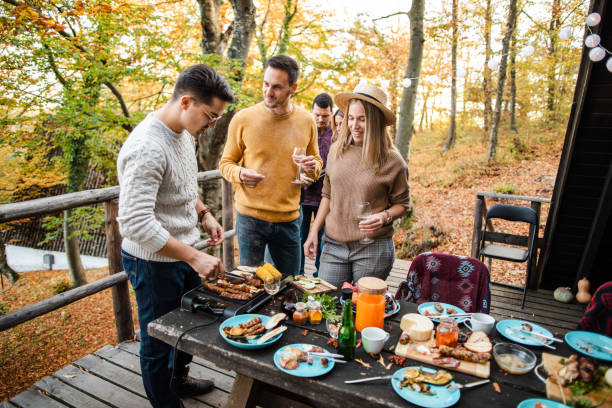

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<start> a group of people sitting around a table eating pizza . <end>


In [94]:
display_png(Image('istockphoto-1188421171-612x612.png'))
!python sample.py --image='istockphoto-1188421171-612x612.png'

回答：

'main_pc.png'　＝　a motorcycle parked in a field next to a body of water .　和訳：水辺の野原に停められたバイク 

'istockphoto-1188421171-612x612.png' = a group of people sitting around a table eating pizza . 和訳：テーブルを囲んでピザを食べている人たち

## 【問題3】Kerasで動かしたい場合はどうするかを調査

PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。

どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。



**回答：モデル移植を行う**

その際の注意点


*   BatchNormalizationのデフォルト値が異なる
*   PyTorchではOptimizerでWeight Decayを指定するが、Tensorflow /Kerasではレイヤーで指定する
*   画像入力の形式の違い　1.PyTpoch（CNN等）NCHW形式　2.
TensorFlow/Keras　NHWCがデフォルト




